# Блок №10 А/А тесты

# Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

# Описание колонок
+ `experimentVariant` – вариант эксперимента
+ `version` – версия приложения
+ `purchase` – факт покупки
 

# Задача
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста
 

💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

+ Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
+ Посчитайте pvalue для каждой версии МП
+ Найдите версии, где pvalue < 0.05
+ Исключите версию с pvalue < 0.05 из основного датафрейма
+ Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
+ Вы нашли поломку

# Материалы
+ [Данные](https://stepik.org/media/attachments/lesson/396012/hw_aa.csv)

In [1]:
# Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
# Путь до файла
path = '/home/jupyter-a.stamati-16/Statistic/hw_aa.csv'

In [3]:
# Загрузим данные и переименуем первую колонку в id пользователя
hw = pd.read_csv(path, sep=';').rename(columns={'Unnamed: 0': 'id_client'})

In [4]:
hw.shape

(127018, 5)

In [5]:
hw.head()

,id_client,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [6]:
hw.dtypes

id_client             int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

###  Запустим A/A-тест

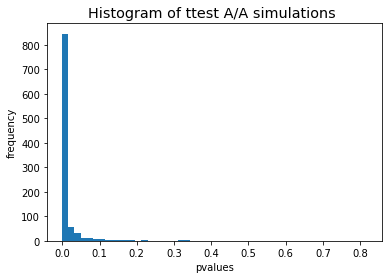

0.934

In [7]:
n = 100000 # Размер выбоки
simulations = 1000 # Количество симуляций
n_s = 1000 # Размер подвиборок
res = [] # Список для хранения значений p-value

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = hw \
            .query('experimentVariant == 1') \
            .purchase \
            .sample(n_s, replace = False) \
            .values
    s2 = hw \
            .query('experimentVariant == 0') \
            .purchase \
            .sample(n_s, replace = False) \
            .values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Полученние значение FPR > альфа - это означет, что сплитирование работает не корректно

### Посчитаем конверсию

In [8]:
# Посчитаем конверсию и количество лючедей в разрезе варианта эксперимента и версии приложения
hw_1 = hw.groupby(['experimentVariant', 'version'], as_index=False) \
    .agg({'purchase': 'mean', 'id_client':'count'}) \
    .assign(purchase =  lambda x: x['purchase'] * 100) \
    .rename(columns={'purchase' : 'conversion', 'id_client' : 'client_count'}) 
    
hw_1

,experimentVariant,version,conversion,client_count
0,0,v2.8.0,0.099314,41283
1,0,v2.9.0,7.465817,11921
2,0,v3.7.4.0,5.994291,4204
3,0,v3.8.0.0,5.760450,5694
4,1,v2.8.0,4.560551,41552
5,1,v2.9.0,7.130391,12033
6,1,v3.7.4.0,6.301824,4221
7,1,v3.8.0.0,6.284779,6110


Мы видим, что в версии приложения v2.8.0 есть очень большие расхождения по конверсии, хотя размеры групп очень близкие в них, поэтому проведем новый эксперимент уже без этой версии приложения и посмотрим на результаты

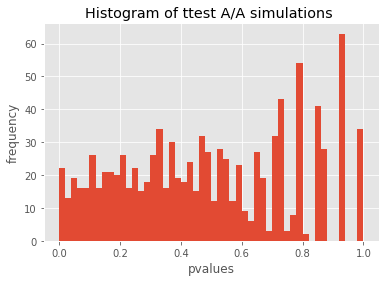

0.047

In [9]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = hw \
            .query('experimentVariant == 1 and version != "v2.8.0"') \
            .purchase \
            .sample(n_s, replace = False) \
            .values
    s2 = hw \
            .query('experimentVariant == 0 and version != "v2.8.0"') \
            .purchase \
            .sample(n_s, replace = False) \
            .values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Получешенное значение FPR < альфа -  дает понмаиние, что без версии приложения v2.8.0 сплитирование работает корректо, значит основная проблема в данной версии. Проблема может быть в сборе данных, возможно неправильно записали дынне о для варианта эксперимента (experimentVariant) = 0